In [35]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import quandl

In [36]:
quandl.ApiConfig.api_key = "Xj7H17zGhd5xUBivja-R"

In [37]:
def get_change_last_symbol(symbol):
    return "change_last_" + symbol


def get_symbol_name(column_name):
    return column_name.rsplit('_', 1)[-1]


def get_symbols_dict(row, prefix):
    symbols = {}
    for key, value in row[1].items():
        if key.startswith(prefix):
            symbols[get_symbol_name(key)] = value
            
    return symbols


def get_symbols_list(row, prefix):
    symbols = []
    for key, value in row[1].items():
        if key.startswith(prefix):
            symbols.append({"name": get_symbol_name(key), "value": value})
            
    return symbols


def prefix_symbol_names(symbols_names, prefix):
    prefixed_names = []
    for name in symbols_names:
        prefixed_names.append(prefix + name)
        
    prefixed_names

In [38]:
def get_prices_frame(symbols):
    prices_frame = None
    for symbol in symbols:
        prices = quandl.get(symbol)
        prices = prices.add_suffix("_" + symbol)
        
        if prices_frame is None:
            prices_frame = prices
            continue
            
        prices_frame = prices_frame.join(prices, how='outer')
        
    return prices_frame

In [39]:
def add_returns(prices_frame, symbol_names, rates_prefix):
    for name in symbol_names:
        for period in range(2, 14):
            prices_frame["return_1_rolling_mean_{}_{}".format(period, name)] = prices_frame[rates_prefix + name].pct_change(periods=1).rolling(period).mean()
            
    for name in symbol_names:
        for period in range(1, 14):
            prices_frame["return_{}_{}".format(period, name)] = prices_frame[rates_prefix + name].pct_change(periods=period)
            
    return prices_frame

In [40]:
# simplification, does not consider if orders could have been actually filled

class Portfolio:
    def __init__(self, cash, log=True):
        self.positions = {}
        self.cash = cash
        self.log = log

    def buy_by_value(self, prices, symbol, value):
        price = prices[symbol]
        amount = value / price
        
        value = float(value)
        if round(value, 4) > round(self.cash, 4):
            raise ValueError("buy_by_value: insufficient funds buy: {} price: {} amount: {} value: {} cash: {}".format(symbol, price, amount, value, self.get_cash()))

        self.add_position_amount(symbol, amount)
        self.cash -= value
        
        if self.log:
            print("bought: {} price: {} amount: {} value: {} cash: {}".format(symbol, round(price, 2), round(amount, 2), round(value, 2), round(self.get_cash(), 2)))

    def sell_all(self, prices, symbol):
        if self.get_position_amount(symbol) > 0:
            self.sell_by_amount(prices, symbol, self.get_position_amount(symbol))

    def sell_by_amount(self, prices, symbol, amount):
        if amount > self.get_position_amount(symbol):
            raise ValueError("sell_by_amount: insufficient funds")

        price = prices[symbol]

        self.remove_position_amount(symbol, amount)
        
        value = price * amount
        self.cash += value
        
        if self.log:
            if value < 50:
                verb = "rebalanced"
            else:
                verb = "sold"
                
            print("{}: {} price: {} amount: {} value: {} cash: {}".format(verb, symbol, round(price, 2), round(amount, 2), round(value, 2), round(self.get_cash(), 2)))

    def sell_by_value(self, prices, symbol, value):
        if value > self.get_position_value(prices, symbol):
            raise ValueError("sell_by_cash: insufficient funds")

        amount = value / prices[symbol]
        self.sell_by_amount(prices, symbol, amount)

    def print_value(self, prices):
        pass
        print("\n--- Portfolio Value")
        for symbol, amount in self.positions.items():
            price = prices[symbol]

            value = price * amount

            print("symbol: {} amount: {} value: {}".format(symbol, amount, value))

        print("symbol: positions value: {}".format(self.get_positions_value(prices)))
        print("symbol: cash value: {}".format(self.get_cash()))
        print("symbol: value value: {}".format(self.get_value(prices)))
        print("\n---\n")

    def get_position_amount(self, symbol):
        if symbol not in self.positions:
            self.positions[symbol] = 0

        return self.positions[symbol]

    def add_position_amount(self, symbol, amount):
        self.positions[symbol] += amount

    def remove_position_amount(self, symbol, amount):
        self.positions[symbol] -= amount

    def get_position_value(self, prices, symbol):
        return prices[symbol] * self.get_position_amount(symbol)

    def get_cash(self):
        return self.cash

    def get_value(self, prices):
        return self.get_positions_value(prices) + self.get_cash()

    def get_positions_value(self, prices):
        portfolio_value = 0
        for symbol in self.positions.keys():
            portfolio_value += self.get_position_value(prices, symbol)

        return portfolio_value


In [62]:
def get_winner_names(returns, count, min):
    returns = sorted(returns, key=lambda d: d["value"], reverse=True)
    
    returns = [r for r in returns if r["value"] > min]
    
    return list(map(lambda x: x["name"], returns[:count]))


def get_looser_names(returns, count, min):
    names = list(map(lambda x: x["name"], returns))
    
    winner_names = get_winner_names(returns, count, min)
    
    return [name for name in names if name not in winner_names]


def execute_momentum(portfolio, prices, returns):
    winner_amount = 2
    winner_symbols = get_winner_names(returns, winner_amount, 0)
    looser_symbols = get_looser_names(returns, winner_amount, 0)
    winner_amount = len(winner_symbols)

    for symbol in looser_symbols:
        portfolio.sell_all(prices, symbol)

    portfolio_value = portfolio.get_value(prices)
    
    if winner_amount == 0:
        return portfolio
    
    partial_value = portfolio_value / winner_amount

    for symbol in winner_symbols:
        diff = portfolio.get_position_value(prices, symbol) - partial_value

        if diff > 0:
            portfolio.sell_by_value(prices, symbol, diff)

    for symbol in winner_symbols:
        diff = partial_value - portfolio.get_position_value(prices, symbol)

        if diff > 0:
            portfolio.buy_by_value(prices, symbol, diff)
            
    return portfolio
        
            
def execute_strategy(frame, start, end, return_prefixes, rate_prefix):
    portfolios = []
    
    portfolio_values = {}
    for return_prefix in return_prefixes:
        portfolio = Portfolio(cash=1, log=False)

        portfolio_values[return_prefix] = []
        prices = None
        for row in frame[start:end].iterrows():
            prices = get_symbols_dict(row, rate_prefix)
            returns = get_symbols_list(row, return_prefix)
        
            portfolio = execute_momentum(portfolio, prices, returns)
            
            portfolio_values[return_prefix].append(portfolio.get_value(prices))
              
        portfolios.append({"portfolio": portfolio, "last_prices": prices, "return_prefix": return_prefix})
    
    values_frame = pd.DataFrame(portfolio_values, index=frame[start:end].index)
    
    return sorted(portfolios, key=lambda p: p["portfolio"].get_value(p["last_prices"]), reverse=True), values_frame

In [49]:
#symbols = ["BITFINEX/ETHUSD", "BITFINEX/BTCUSD", "BITFINEX/LTCUSD", "BITFINEX/ZECUSD", "BITFINEX/ETCUSD", "BITFINEX/RRTUSD", "BITFINEX/IOTUSD", "BITFINEX/BCCUSD", "BITFINEX/BCUUSD", "BITFINEX/DSHUSD", "BITFINEX/XMRUSD", "BITFINEX/OMGUSD", "BITFINEX/SANUSD", "BITFINEX/EOSUSD", "BITFINEX/ETPUSD", "BITFINEX/NEOUSD", "BITFINEX/BCHUSD"]
crypto_symbols = ["BITFINEX/ETHUSD", "BITFINEX/BTCUSD", "BITFINEX/LTCUSD", "BITFINEX/ZECUSD"]
crypto_prices_frame = get_prices_frame(crypto_symbols)
crypto_rate_prefix = "Last_"
crypto_prices_frame = add_returns(crypto_prices_frame, crypto_symbols, crypto_rate_prefix)

In [50]:
forex_symbols = ["CUR/MXN", "CUR/JPY", "CUR/INR", "CUR/HKD", "CUR/GBP", "CUR/EUR", "CUR/CNY", "CUR/CHF", "CUR/CAD", "CUR/AUD"]
forex_prices_frame = 1 / get_prices_frame(forex_symbols)
forex_rate_prefix = "RATE_"
forex_prices_frame = add_returns(forex_prices_frame, forex_symbols, forex_rate_prefix)

In [51]:
def benchmark_momentum(start, frequency, prices_frame, rate_prefix):
    return_prefixes = list(set(list(map(lambda c: c.rsplit("_", 1)[0], prices_frame.filter(regex="return").columns))))
    rate_prefixes = prices_frame.filter(regex=rate_prefix).columns

    performances = {}
    from_ = pd.date_range(start, prices_frame.index[-1], freq=frequency).date
    to = np.append(from_[1:],[prices_frame.index[-1]])
    for f, t in zip(from_, to):
        portfolios, _ = execute_strategy(prices_frame, f, t, return_prefixes, rate_prefix)

        if "index" not in performances:
            performances["index"] = []        
        performances["index"].append(f)

        for portfolio in portfolios:
            return_prefix = portfolio["return_prefix"]
            value = portfolio["portfolio"].get_value(portfolio["last_prices"])

            if return_prefix not in performances:
                performances[return_prefix] = []
            performances[return_prefix].append(value)
    
    performance_frame = pd.DataFrame(performances, index=performances["index"])
    performance_frame.drop("index", axis=1, inplace=True)
    
    return performance_frame

In [63]:
forex_momentum_benchmark, values_frame = benchmark_momentum("2016-01-01 00:00:00", "1d", forex_prices_frame, forex_rate_prefix)

ValueError: too many values to unpack (expected 2)

In [ ]:
forex_momentum_benchmark.mean().order(ascending=False)  ** len(forex_momentum_benchmark)

In [ ]:
crypto_momentum_benchmark = benchmark_momentum("2017-01-01 00:00:00", "1d", crypto_prices_frame, crypto_rate_prefix)

In [ ]:
crypto_momentum_benchmark.mean().order(ascending=False) ** len(crypto_momentum_benchmark)

In [ ]:
def execute_strategy_single(frame, start, end, rate_prefix, return_prefix):
    value = []
    portfolio = Portfolio(cash=1000, log=True)

    for row in frame[start:end].iterrows():
        print("------------")
        print(row[0])
        prices = get_symbols_dict(row, rate_prefix)
        returns = get_symbols_list(row, return_prefix)

        portfolio = execute_momentum(portfolio, prices, returns)
        
        value.append(portfolio.get_value(prices))

    return portfolio, 

In [55]:
from pandas_datareader import data
import time

def get_prices_frame_data_reader(symbols):
    prices_frame = None
    for symbol in symbols:
        time.sleep(3)
        prices = data.DataReader(symbol, 'yahoo', datetime.datetime(2017, 1, 1), datetime.datetime(2017, 10, 24))
        prices = prices.add_suffix("_" + symbol)
        
        if prices_frame is None:
            prices_frame = prices
            continue
            
        prices_frame = prices_frame.join(prices, how='outer')
        
    return prices_frame

In [58]:
#stock_symbols = ['AAPL', 'ABT', 'ABBV', 'ACN', 'ACE', 'ADBE', 'ADT', 'AAP', 'AES', 'AET', 'AFL', 'AMG', 'A', 'GAS', 'ARE', 'APD', 'AKAM', 'AA', 'AGN', 'ALXN', 'ALLE', 'ADS', 'ALL', 'ALTR', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'AON', 'APA', 'AIV', 'AMAT', 'ADM', 'AIZ', 'T', 'ADSK', 'ADP', 'AN', 'AZO', 'AVGO', 'AVB', 'AVY', 'BHI', 'BLL', 'BAC', 'BK', 'BCR', 'BXLT', 'BAX', 'BBT', 'BDX', 'BBBY', 'BRK.B', 'BBY', 'BLX', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BMY', 'BRCM', 'BF.B', 'CHRW', 'CA', 'CVC', 'COG', 'CAM', 'CPB', 'COF', 'CAH', 'HSIC', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHK', 'CVX', 'CMG', 'CB', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CTXS', 'CLX', 'CME', 'CMS', 'COH', 'KO', 'CCE', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CSC', 'CAG', 'COP', 'CNX', 'ED', 'STZ', 'GLW', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DLPH', 'DAL', 'XRAY', 'DVN', 'DO', 'DTV', 'DFS', 'DISCA', 'DISCK', 'DG', 'DLTR', 'D', 'DOV', 'DOW', 'DPS', 'DTE', 'DD', 'DUK', 'DNB', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMC', 'EMR', 'ENDP', 'ESV', 'ETR', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ES', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'XOM', 'FFIV', 'FB', 'FAST', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FTI', 'F', 'FOSL', 'BEN', 'FCX', 'FTR', 'GME', 'GPS', 'GRMN', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GNW', 'GILD', 'GS', 'GT', 'GOOGL', 'GOOG', 'GWW', 'HAL', 'HBI', 'HOG', 'HAR', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HCN', 'HP', 'HES', 'HPQ', 'HD', 'HON', 'HRL', 'HSP', 'HST', 'HCBK', 'HUM', 'HBAN', 'ITW', 'IR', 'INTC', 'ICE', 'IBM', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IRM', 'JEC', 'JBHT', 'JNJ', 'JCI', 'JOY', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'GMCR', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KRFT', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LM', 'LEG', 'LEN', 'LVLT', 'LUK', 'LLY', 'LNC', 'LLTC', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MNK', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MCK', 'MJN', 'MMV', 'MDT', 'MRK', 'MET', 'KORS', 'MCHP', 'MU', 'MSFT', 'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MUR', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NEE', 'NLSN', 'NKE', 'NI', 'NE', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NRG', 'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'OI', 'PCAR', 'PLL', 'PH', 'PDCO', 'PAYX', 'PNR', 'PBCT', 'POM', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PBI', 'PCL', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PCP', 'PCLN', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RRC', 'RTN', 'O', 'RHT', 'REGN', 'RF', 'RSG', 'RAI', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RLD', 'R', 'CRM', 'SNDK', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SRE', 'SHW', 'SPG', 'SWKS', 'SLG', 'SJM', 'SNA', 'SO', 'LUV', 'SWN', 'SE', 'STJ', 'SWK', 'SPLS', 'SBUX', 'HOT', 'STT', 'SRCL', 'SYK', 'STI', 'SYMC', 'SYY', 'TROW', 'TGT', 'TEL', 'TE', 'TGNA', 'THC', 'TDC', 'TSO', 'TXN', 'TXT', 'HSY', 'TRV', 'TMO', 'TIF', 'TWX', 'TWC', 'TJX', 'TMK', 'TSS', 'TSCO', 'RIG', 'TRIP', 'FOXA', 'TSN', 'TYC', 'UA', 'UNP', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'ANTM', 'WFC', 'WDC', 'WU', 'WY', 'WHR', 'WFM', 'WMB', 'WEC', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']  
stock_symbols = ['AAPL', 'TSLA', 'F', 'AMZN', 'GOOGL']
stock_prices_frame = get_prices_frame_data_reader(stock_symbols)
stock_rate_prefix = "Close_"
stock_prices_frame = add_returns(stock_prices_frame, stock_symbols, stock_rate_prefix)

In [ ]:
stock_momentum_benchmark = benchmark_momentum("2017-1-01 00:00:00", "1d", stock_prices_frame, stock_rate_prefix)

In [ ]:
stock_momentum_benchmark.mean().order(ascending=False) ** len(stock_momentum_benchmark)

In [ ]:
portfolio = execute_strategy_single(stock_prices_frame, "2017-1-01 00:00:00", "2017-10-23 00:00:00", stock_rate_prefix, "return_1_rolling_mean_2")

In [ ]:
stock_prices_frame[["Close_AAPL", "return_1_AAPL", "return_1_rolling_mean_2_AAPL", "Close_AMZN",  "return_1_AMZN", "return_1_rolling_mean_2_AMZN"]]

In [65]:
return_prefixes = list(set(list(map(lambda c: c.rsplit("_", 1)[0], stock_prices_frame.filter(regex="return").columns))))
portfolio, values = execute_strategy(stock_prices_frame, "2017-1-01 00:00:00", "2017-10-23 00:00:00", return_prefixes, stock_rate_prefix)

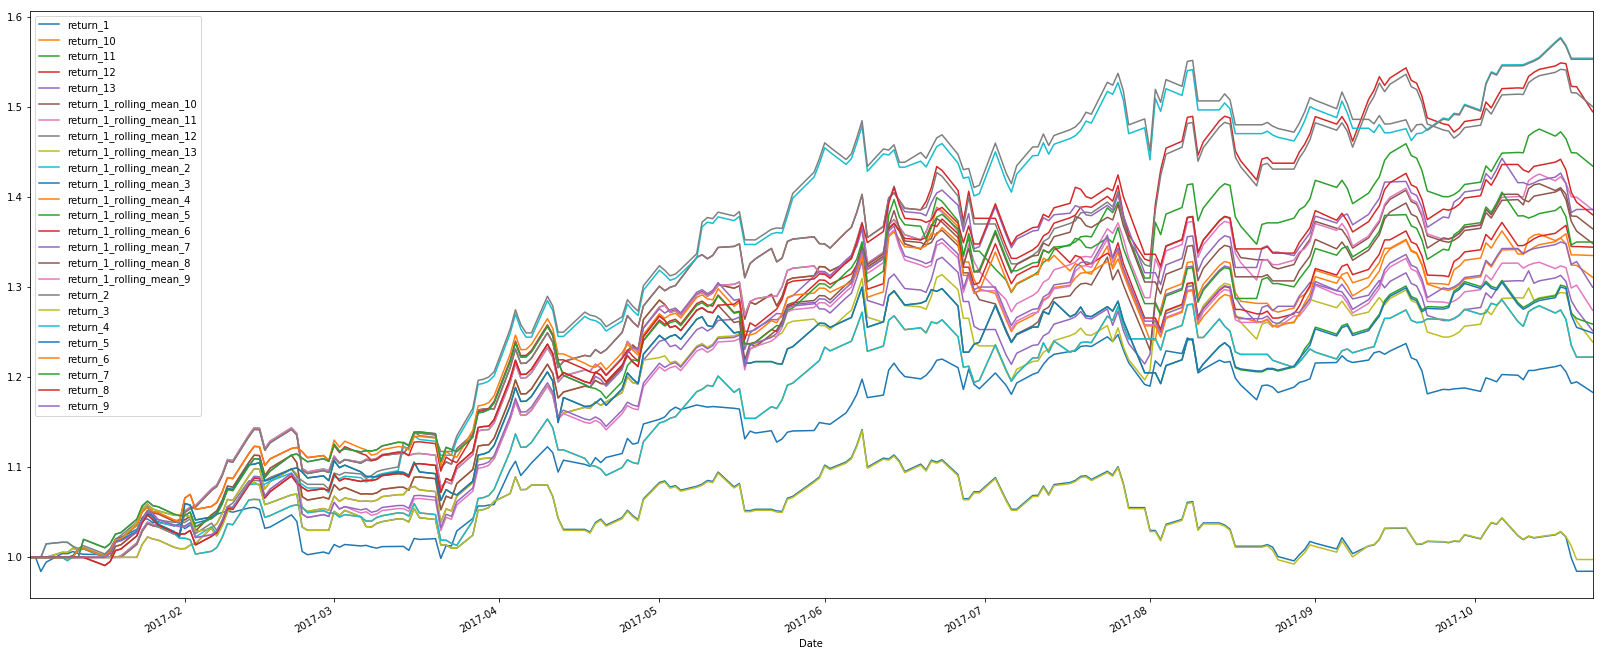

In [69]:
values.plot(figsize=(28, 12))